In [14]:
from enum import auto
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics  import classification_report, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
# Bỏ qua hàng đầu tiên, dùng hàng 2 làm header
df = pd.read_csv("SWAT.csv",header=1, low_memory=False)

In [16]:
time_candidates = [c for c in df.columns if 'time' in c.lower() or 'timestamp' in c.lower()]
if not time_candidates:
    timestamp_col = df.columns[0]
else:
    timestamp_col = time_candidates[0]

df = df[~df[timestamp_col].astype(str).str.lower().eq(timestamp_col.lower())]
df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors="coerce", utc=True)
df = df.dropna(subset=[timestamp_col])
df = df.set_index(timestamp_col)

print("Cột thời gian được sử dụng:", timestamp_col)

Cột thời gian được sử dụng: GMT +0


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18860\1033324384.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors="coerce", utc=True)


In [17]:
attack_periods = [
    # Attack 1: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:08:46', '2019-07-20 07:10:31'),
    # Attack 2: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:15:00', '2019-07-20 07:19:32'),
    # Attack 3: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:26:57', '2019-07-20 07:30:48'),
    # Attack 4: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:38:50', '2019-07-20 07:46:20'),
    # Attack 5: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:54:00', '2019-07-20 07:56:00'),
    # Attack 6: 16h (GMT+8) -> 8h (GMT+0)
    ('2019-07-20 08:02:56', '2019-07-20 08:16:18')
]

attack_datetime_periods = [
    (pd.to_datetime(start).tz_localize("UTC"), pd.to_datetime(end).tz_localize("UTC"))
    for start, end in attack_periods
]

df['Attack'] = 0
for start, end in attack_datetime_periods:
    df.loc[start:end, 'Attack'] = 1

print("Số mẫu Attack:", df['Attack'].sum())
print("Tỷ lệ Attack:", df['Attack'].mean() * 100)

Số mẫu Attack: 1981
Tỷ lệ Attack: 13.210189383835688


In [18]:
plt.rcParams['figure.figsize'] = (15, 5)
status_cols = [col for col in df.columns if df[col].astype(str).str.contains("Active|Inactive", case=False).any()]

print("\n Các cột có Active/Inactive:", status_cols)

for col in status_cols:
    df[col] = df[col].map({'Active': 1, 'Inactive': 0})

# print(df[status_cols].head())

target_column = 'Attack'
feature_columns = df.columns.drop(target_column)

for col in feature_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

feature_std = df[feature_columns].std()
useless_columns = feature_std[feature_std == 0].index

if not useless_columns.empty:
    print("\nCác cột không có biến thiên (std=0) và có thể loại bỏ:")
    print(list(useless_columns))
    print("Số cột bị loại bỏ:", len(useless_columns))
    # df.drop(columns=useless_columns, inplace=True)
else:
    print("\nKhông có cột nào bị loại bỏ do không có biến thiên.")


 Các cột có Active/Inactive: ['LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'LS 401', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603']

Các cột không có biến thiên (std=0) và có thể loại bỏ:
['P102 Status', 'LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'P2_STATE', 'P201 Status', 'P202 Status', 'P204 Status', 'P206 Status', 'P207 Status', 'P208 Status', 'P302 Status', 'AIT 401', 'LS 401', 'P4_STATE', 'P402 Status', 'P403 Status', 'P404 Status', 'MV 502', 'MV 503', 'MV 504', 'P5_STATE', 'P501 Status', 'P502 Status', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603', 'P6 STATE', 'P602 Status', 'P603 Status']
Số cột bị loại bỏ: 33


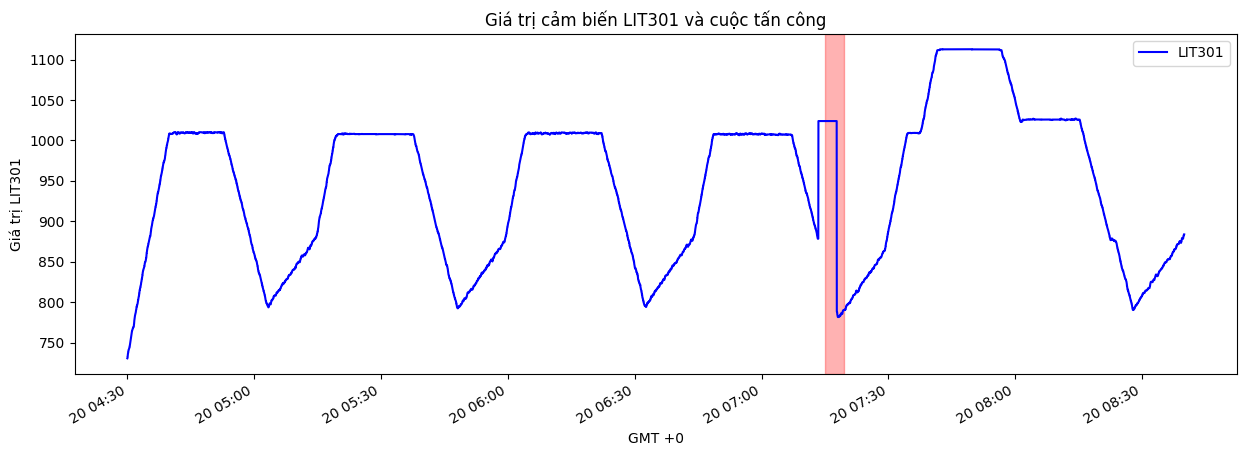

In [19]:
# --------------------------------------------------------------------------------
# Visualize attack periods on a specific sensor
fig, ax = plt.subplots()  

df['LIT 301'].plot(ax=ax, label='LIT301', color='blue')

start,end = attack_datetime_periods[1]
ax.axvspan(start, end, color='red', alpha=0.3, label ='_nolegend_')

ax.set_title('Giá trị cảm biến LIT301 và cuộc tấn công')
ax.set_ylabel('Giá trị LIT301')
ax.legend()
plt.show()


Không tìm thấy cột nào chứa toàn giá trị NaN.


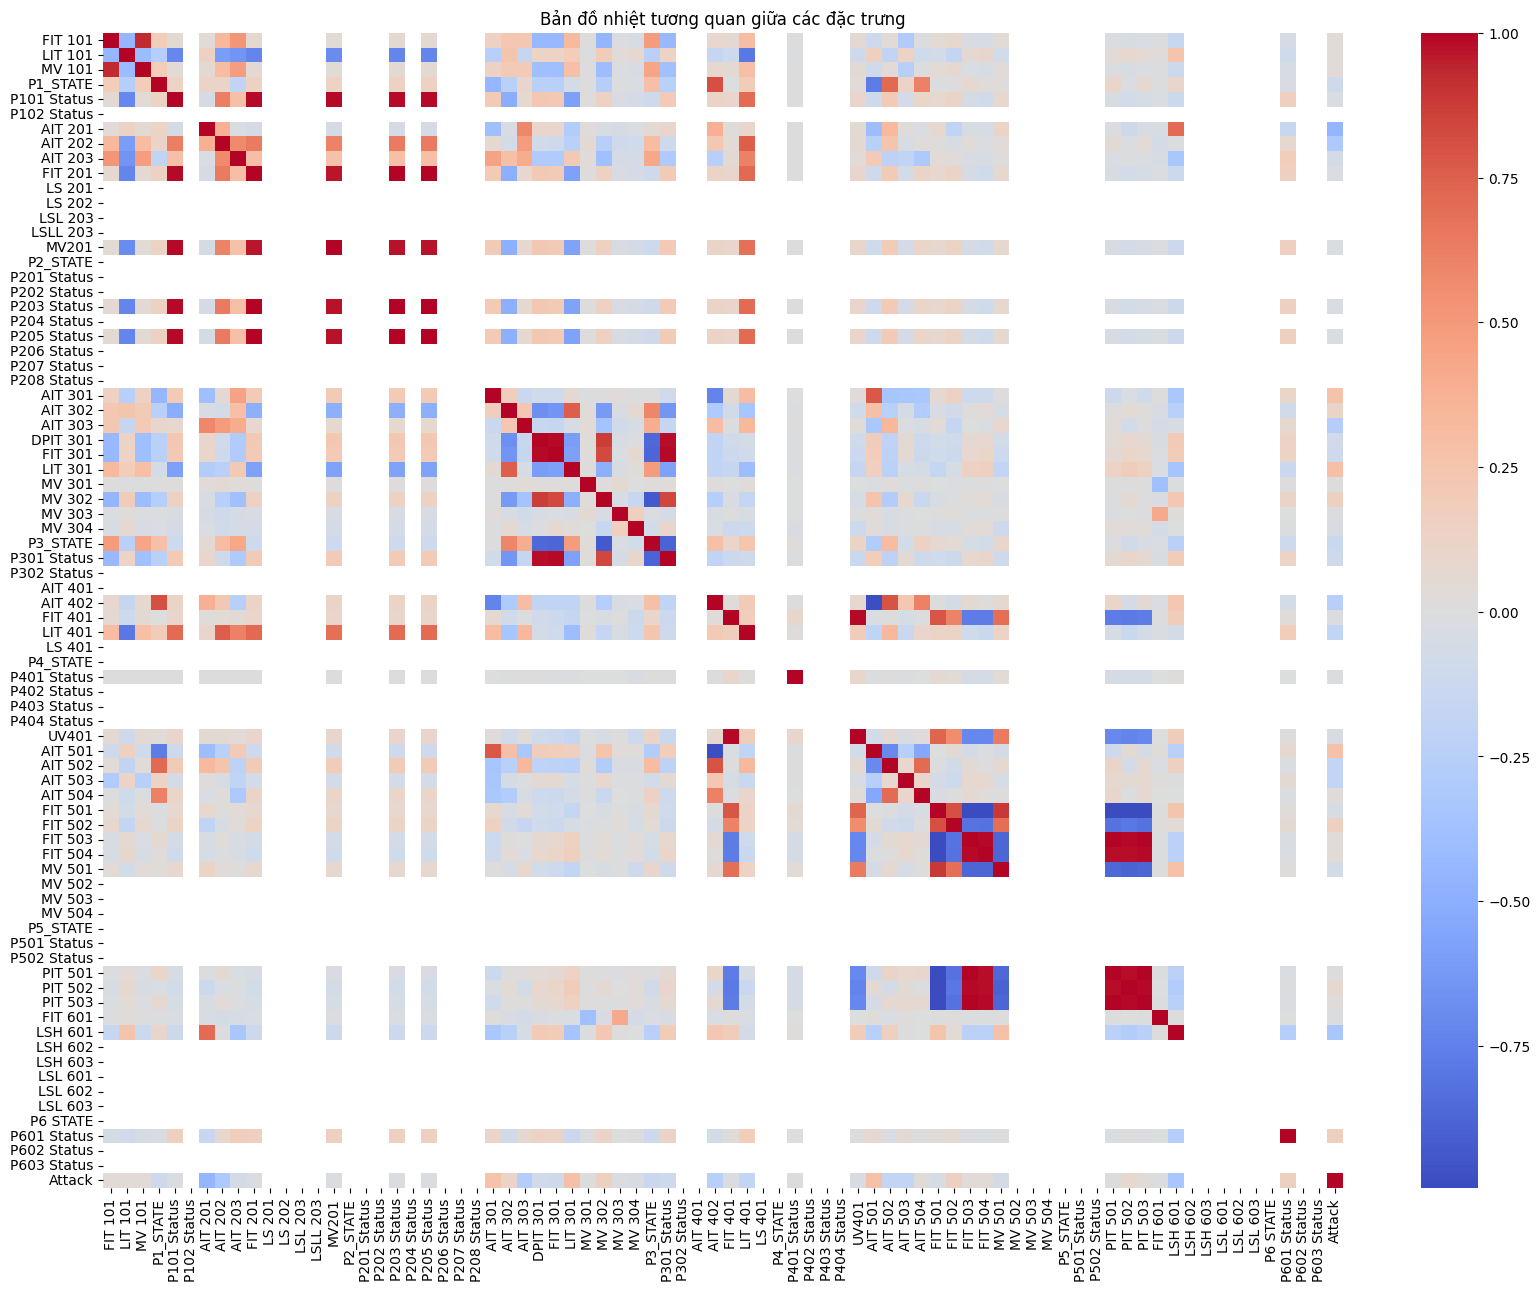

In [20]:
#--------------------------------------------------------------------------------\
# Feature correlations analysis

nan_columns = df.columns[df.isnull().all()]

if not nan_columns.empty:
    print("\nCÁC CỘT BỊ TRỐNG TRÊN HEATMAP (do toàn giá trị NaN):")
    print(list(nan_columns))
else:
    print("\nKhông tìm thấy cột nào chứa toàn giá trị NaN.")

corr_matrix = df.corr() 

plt.figure(figsize=(20, 15))

sns.heatmap(corr_matrix, cmap='coolwarm', center=0)

plt.title('Bản đồ nhiệt tương quan giữa các đặc trưng')

plt.show()

In [21]:
#---------------------------------------------------------------------------------
# Select top features based on correlation with 'Attack'

selected_features = ['FIT 101', 'LIT 101', 'MV 101', 'P1_STATE', 'P101 Status', 'AIT 201', 'AIT 202', 'AIT 203', 'FIT 201', 'MV201', 'P203 Status', 'P205 Status',
                    'AIT 301', 'AIT 302', 'AIT 303', 'DPIT 301', 'FIT 301', 'LIT 301', 'MV 301', 'MV 302', 'MV 303', 'MV 304', 'P3_STATE', 'P301 Status', 
                    'AIT 402', 'FIT 401', 'LIT 401', 'P401 Status', 'UV401', 'AIT 501', 'AIT 502', 'AIT 503', 'AIT 504', 'FIT 501', 'FIT 502', 'FIT 503',
                    'FIT 504', 'MV 501', 'PIT 501', 'PIT 502', 'PIT 503', 'FIT 601', 'LSH 601', 'P601 Status']


df_model = df[selected_features + ['Attack']].copy()

print(f"Đã tạo DataFrame mới với {len(selected_features)} đặc trưng được chọn.")

print(df_model.head())


Đã tạo DataFrame mới với 44 đặc trưng được chọn.
                                  FIT 101   LIT 101  MV 101  P1_STATE  \
GMT +0                                                                  
2019-07-20 04:30:00+00:00             0.0  729.8658       1         3   
2019-07-20 04:30:01+00:00             0.0  729.4340       1         3   
2019-07-20 04:30:02.004013+00:00      0.0  729.1200       1         3   
2019-07-20 04:30:03.004013+00:00      0.0  728.6882       1         3   
2019-07-20 04:30:04+00:00             0.0  727.7069       1         3   

                                  P101 Status     AIT 201   AIT 202  \
GMT +0                                                                
2019-07-20 04:30:00+00:00                   2  142.527557  9.293002   
2019-07-20 04:30:01+00:00                   2  142.527557  9.293002   
2019-07-20 04:30:02.004013+00:00            2  142.527557  9.293002   
2019-07-20 04:30:03.004013+00:00            2  142.527557  9.289157   
2019-07-20 04

In [22]:
#---------------------------------------------------------------------------------
# missing value imputation


print(f"Số giá trị NaN trước khi xử lý: {df_model.isnull().sum().sum()}")

df_model.ffill(inplace=True)

df_model.bfill(inplace=True)

print(f"Số giá trị NaN sau khi xử lý: {df_model.isnull().sum().sum()}")

Số giá trị NaN trước khi xử lý: 0
Số giá trị NaN sau khi xử lý: 0


In [23]:
df_full = df_model.copy()

scaler_full = MinMaxScaler(feature_range=(-1, 1))
X_full_scaled = scaler_full.fit_transform(df_full[selected_features])


In [24]:
#---------------------------------------------------------------------------------
# Train LSTM Autoencoder model

def create_sequences(X, time_steps=10): 
    Xs = []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
    return np.array(Xs)

TIME_STEPS = 10

X_full_seq = create_sequences(X_full_scaled, TIME_STEPS)  

y_full_seq = []
y_full = df_full['Attack'].values  

for i in range(len(y_full) - TIME_STEPS):
    if 1 in y_full[i:i + TIME_STEPS]:
        y_full_seq.append(1)
    else:
        y_full_seq.append(0)
y_full_seq = np.array(y_full_seq)

print(f"Tổng số chuỗi dữ liệu: {X_full_seq.shape}")
print("Chuẩn bị dữ liệu toàn cục hoàn tất.\n")

Tổng số chuỗi dữ liệu: (14986, 10, 44)
Chuẩn bị dữ liệu toàn cục hoàn tất.



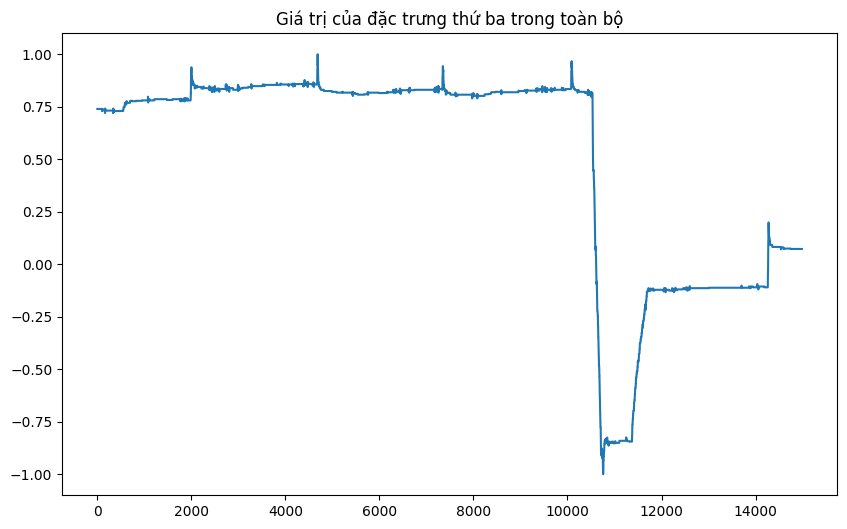

In [25]:
plt.figure(figsize=(10,6))
plt.plot(X_full_seq[:14988,0, 5])
plt.title('Giá trị của đặc trưng thứ ba trong toàn bộ')
plt.show()

In [26]:
# initialize LSTM model, first guess

def build_lstm_autoencoder(time_steps, features):
    model = Sequential([
        LSTM(32, activation='tanh', input_shape=(time_steps, features), return_sequences=True),
        LSTM(16, activation='tanh', return_sequences=False),
        RepeatVector(time_steps),
        LSTM(16, activation='tanh', return_sequences=True),
        LSTM(32, activation='tanh', return_sequences=True),
        TimeDistributed(Dense(features, activation='tanh'))
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

n_time_steps, n_features = X_full_seq.shape[1], X_full_seq.shape[2]
initial_model = build_lstm_autoencoder(n_time_steps, n_features)

initial_model.fit(X_full_seq, X_full_seq, 
                  epochs=10, 
                  batch_size=64, 
                  validation_split=0.1, 
                  shuffle=True, 
                  verbose=1)

initial_loss = np.mean(np.abs(initial_model.predict(X_full_seq) - X_full_seq), axis=(1,2))

contamination_ratio = 0.2
num_normal_samples = int(len(X_full_seq) * (1 - contamination_ratio))
normal_indices = np.argsort(initial_loss)[:num_normal_samples]
X_train_current = X_full_seq[normal_indices]

print(f"\nTập train ban đầu được tạo với {len(X_train_current)} mẫu.")
print("Khởi tạo hoàn tất.\n")

Epoch 1/10


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.1938 - val_loss: 0.0729
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0505 - val_loss: 0.0588
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0319 - val_loss: 0.0541
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0236 - val_loss: 0.0538
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0194 - val_loss: 0.0546
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0161 - val_loss: 0.0567
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0146 - val_loss: 0.0561
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0131 - val_loss: 0.0607
Epoch 9/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0121 - val_loss: 0.0595
Epoch 10/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0113 - val_loss: 0.0601
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

Tập train ban đầu được tạo với 11988 mẫu.
Khởi tạo hoàn tất.



In [27]:
# Start iterative training
NUM_ITERATIONS = 5
final_model = None

for i in range(NUM_ITERATIONS):
    print(f"\n==== Vòng lặp huấn luyện thứ {i+1}/{NUM_ITERATIONS} ====")

    model_iter = build_lstm_autoencoder(n_time_steps, n_features)

    early_stopping_iter = EarlyStopping(monitor='loss', patience=5, mode='min', restore_best_weights=True)

    model_iter.fit(X_train_current, X_train_current,
                    epochs=50,
                    batch_size=64,
                    shuffle=True,
                    callbacks=[early_stopping_iter],
                    verbose=0)
    
    print("Tính toán lại lỗi trên toàn bộ dataset...")
    full_mae_loss = np.mean(np.abs(model_iter.predict(X_full_seq) - X_full_seq), axis=(1,2))

    sorted_indices = np.argsort(full_mae_loss)
    new_normal_indices = sorted_indices[:num_normal_samples]
    X_train_next = X_full_seq[new_normal_indices]

    changed_samples = len(np.setdiff1d(normal_indices, new_normal_indices))
    print(f"Số mẫu thay đổi trong tập train: {changed_samples}")

    X_train_current = X_train_next
    normal_indices = new_normal_indices
    final_model = model_iter

    if changed_samples == 0:     # Dừng nếu không có thay đổi
        print(f"Tập train đã hội tụ ở vòng lặp thứ {i+1}! Dừng huấn luyện sớm.")
        break

print("\nHuấn luyện hoàn tất.\n")


==== Vòng lặp huấn luyện thứ 1/5 ====
Tính toán lại lỗi trên toàn bộ dataset...
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Số mẫu thay đổi trong tập train: 107

==== Vòng lặp huấn luyện thứ 2/5 ====
Tính toán lại lỗi trên toàn bộ dataset...
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Số mẫu thay đổi trong tập train: 66

==== Vòng lặp huấn luyện thứ 3/5 ====
Tính toán lại lỗi trên toàn bộ dataset...
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Số mẫu thay đổi trong tập train: 47

==== Vòng lặp huấn luyện thứ 4/5 ====
Tính toán lại lỗi trên toàn bộ dataset...
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Số mẫu thay đổi trong tập train: 38

==== Vòng lặp huấn luyện thứ 5/5 ====
Tính toán lại lỗi trên toàn bộ dataset...
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Số mẫu thay đổi trong tập train: 34

Huấn luyện hoàn tất.



469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Ngưỡng phát hiện dị thường được đặt tại: 0.025897682791312396

----------Báo cáo phân loại(Iterative Training): ----------
              precision    recall  f1-score   support

  Normal (0)       0.87      0.80      0.83     12951
  Attack (1)       0.15      0.23      0.18      2035

    accuracy                           0.72     14986
   macro avg       0.51      0.51      0.51     14986
weighted avg       0.77      0.72      0.74     14986

Ma trận nhầm lẫn:
[[10305  2646]
 [ 1563   472]]


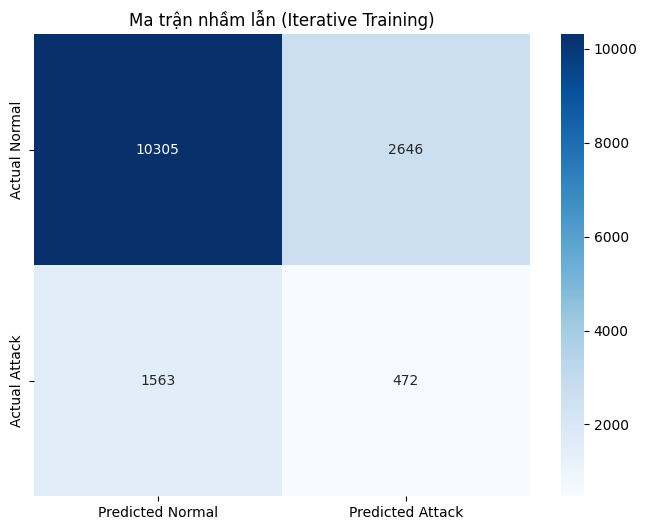

Quy trình hoàn tất.


In [28]:
# Evaluate the final model

final_loss = np.mean(np.abs(final_model.predict(X_full_seq) - X_full_seq), axis=(1, 2))

normal_errors = final_loss[normal_indices]
threshold = np.percentile(normal_errors, 99)
print(f"Ngưỡng phát hiện dị thường được đặt tại: {threshold}")

predictions = (final_loss > threshold).astype(int)

print("\n----------Báo cáo phân loại(Iterative Training): ----------")
print(classification_report(y_full_seq, predictions, target_names=['Normal (0)', 'Attack (1)']))

print("Ma trận nhầm lẫn:")
cm_iterative = confusion_matrix(y_full_seq, predictions)
print(cm_iterative)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_iterative, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Attack'],
            yticklabels=['Actual Normal', 'Actual Attack'])
plt.title('Ma trận nhầm lẫn (Iterative Training)')
plt.show()

print("Quy trình hoàn tất.")

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_full_seq, final_loss)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nNgưỡng Tối ưu dựa trên F1-Score: {optimal_threshold:.4f}")
print(f"F1-Score cao nhất có thể đạt được: {f1_scores[optimal_idx]:.4f}")

# Đánh giá lại với ngưỡng tối ưu
optimal_predictions = (final_loss > optimal_threshold).astype(int)
print("\n--- Báo cáo Phân loại với Ngưỡng Tối ưu ---")
print(classification_report(y_full_seq, optimal_predictions, target_names=['Normal (0)', 'Attack (1)']))


Ngưỡng Tối ưu dựa trên F1-Score: 0.0167
F1-Score cao nhất có thể đạt được: 0.2636

--- Báo cáo Phân loại với Ngưỡng Tối ưu ---
              precision    recall  f1-score   support

  Normal (0)       0.89      0.73      0.80     12951
  Attack (1)       0.19      0.41      0.26      2035

    accuracy                           0.69     14986
   macro avg       0.54      0.57      0.53     14986
weighted avg       0.79      0.69      0.73     14986

